# NYC Airbnb Data Analysis (2019)

## Project Goal
Let's explore the 2019 Airbnb dataset for New York City. I want to understand the market: where are the listings concentrated, what are the typical prices, what types of rooms are available, and what factors might influence the price? The plan is to clean the data, perform some exploratory analysis (EDA) with Python, and then export a clean version that I can use to build some cool dashboards in Tableau later. This version uses `kagglehub` to download the dataset directly.

## 1. Setup and Data Loading

First things first, let's import the libraries we'll need. We'll use `kagglehub` to download the dataset directly. Make sure you have `kagglehub` installed (`pip install kagglehub`) and have authenticated Kaggle locally (e.g., placed your `kaggle.json` API token correctly).

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
import kagglehub # Import kagglehub

# --- Setup ---
warnings.filterwarnings('ignore') # Ignore warnings for cleaner output
pd.set_option('display.max_columns', 50) # Show more columns
plt.style.use('seaborn-v0_8-whitegrid') # Use a nice plot style
sns.set_palette("viridis") # Set a color palette

print("Libraries imported.")

# Define output path
OUTPUT_DIR = 'output'
OUTPUT_FILE = os.path.join(OUTPUT_DIR, 'nyc_airbnb_cleaned.csv')

# Create output directory if it doesn't exist
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

# --- Load Data using KaggleHub ---
DATASET_SLUG = "dgomonov/new-york-city-airbnb-open-data"
EXPECTED_FILENAME = 'AB_NYC_2019.csv' # The specific CSV file within the dataset

try:
    print(f"Downloading dataset '{DATASET_SLUG}'...")
    # Download the dataset, kagglehub returns the path to the downloaded folder
    dataset_path = kagglehub.dataset_download(DATASET_SLUG)
    print("Dataset download complete.")

    # Construct the full path to the CSV file
    csv_file_path = os.path.join(dataset_path, EXPECTED_FILENAME)
    print(f"Reading CSV file from: {csv_file_path}")

    # Parse 'last_review' as dates during loading
    df = pd.read_csv(csv_file_path, parse_dates=['last_review'])
    print(f"Data loaded successfully. Shape: {df.shape}")

except Exception as e:
    print(f"---! ERROR loading data via kagglehub !---")
    print(e)
    print("Please ensure 'kagglehub' is installed and your Kaggle API token is configured correctly.")
    df = pd.DataFrame() # Create empty df to avoid subsequent errors

# Display first few rows and info only if df is not empty
if not df.empty:
    print("\nFirst 5 rows:")
    display(df.head())
    print("\nDataFrame Info:")
    df.info()

/Users/keivanderafshian/opt/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/Users/keivanderafshian/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:61: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.4' currently installed).
  from pandas.core import (


Libraries imported.


100%|██████████████████████████████████████| 2.44M/2.44M [00:00<00:00, 4.74MB/s]

Extracting files...


Dataset download complete.
Reading CSV file from: /Users/keivanderafshian/.cache/kagglehub/datasets/dgomonov/new-york-city-airbnb-open-data/versions/3/AB_NYC_2019.csv
Data loaded successfully. Shape: (48895, 16)

First 5 rows:


,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaT,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0



DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48895 entries, 0 to 48894
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   id                              48895 non-null  int64         
 1   name                            48879 non-null  object        
 2   host_id                         48895 non-null  int64         
 3   host_name                       48874 non-null  object        
 4   neighbourhood_group             48895 non-null  object        
 5   neighbourhood                   48895 non-null  object        
 6   latitude                        48895 non-null  float64       
 7   longitude                       48895 non-null  float64       
 8   room_type                       48895 non-null  object        
 9   price                           48895 non-null  int64         
 10  minimum_nights                  48895 non-null  int64

## 2. Initial Cleaning and Exploration

Now, let's get a feel for the data. I'll check for missing values, look at basic statistics, and see what kind of data is in the categorical columns.

In [2]:
if not df.empty:
    # --- Check Missing Values ---
    print("\nMissing values per column (%):")
    missing_percentage = (df.isnull().sum() / len(df)) * 100
    print(missing_percentage[missing_percentage > 0].sort_values(ascending=False))

    # --- Handle Missing Reviews Data ---
    # 'reviews_per_month' and 'last_review' have about 20% missing.
    # This likely happens when 'number_of_reviews' is 0. Let's check.
    reviews_missing = df[df['reviews_per_month'].isnull()]
    print(f"\nNumber of rows with missing reviews_per_month: {len(reviews_missing)}")
    print(f"Number of those rows where number_of_reviews is 0: {len(reviews_missing[reviews_missing['number_of_reviews'] == 0])}")

    # It seems the missing values directly correspond to listings with 0 reviews.
    # So, filling 'reviews_per_month' with 0 makes sense.
    df['reviews_per_month'].fillna(0, inplace=True)
    print("Filled missing 'reviews_per_month' with 0.")

    # We'll leave 'last_review' as NaT (Not a Time) for now. We can decide later if we need it.
    # Also small number of missing host_name and name - probably okay to ignore for now.

    # --- Basic Statistics ---
    print("\nDescriptive statistics for numerical columns:")
    # Focusing on potentially interesting columns
    display(df[['price', 'minimum_nights', 'number_of_reviews', 'reviews_per_month', 'calculated_host_listings_count', 'availability_365']].describe())

    # --- Explore Categorical Columns ---
    print("\nUnique values in key categorical columns:")
    print(f"Neighbourhood Groups: {df['neighbourhood_group'].unique()}")
    print(f"Room Types: {df['room_type'].unique()}")
    print(f"Number of unique Neighbourhoods: {df['neighbourhood'].nunique()}")
else:
    print("DataFrame is empty, skipping cleaning and exploration.")


Missing values per column (%):
last_review          20.558339
reviews_per_month    20.558339
host_name             0.042949
name                  0.032723
dtype: float64

Number of rows with missing reviews_per_month: 10052
Number of those rows where number_of_reviews is 0: 10052
Filled missing 'reviews_per_month' with 0.

Descriptive statistics for numerical columns:


,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
count,48895.000000,48895.000000,48895.000000,48895.000000,48895.000000,48895.000000
mean,152.720687,7.029962,23.274466,1.090910,7.143982,112.781327
std,240.154170,20.510550,44.550582,1.597283,32.952519,131.622289
min,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000
25%,69.000000,1.000000,1.000000,0.040000,1.000000,0.000000
50%,106.000000,3.000000,5.000000,0.370000,1.000000,45.000000
75%,175.000000,5.000000,24.000000,1.580000,2.000000,227.000000
max,10000.000000,1250.000000,629.000000,58.500000,327.000000,365.000000



Unique values in key categorical columns:
Neighbourhood Groups: ['Brooklyn' 'Manhattan' 'Queens' 'Staten Island' 'Bronx']
Room Types: ['Private room' 'Entire home/apt' 'Shared room']
Number of unique Neighbourhoods: 221


**Observations:**
* Okay, confirmed that missing review data relates to listings with zero reviews. Filling `reviews_per_month` with 0 seems reasonable.
* The `price` column is interesting: min is $0, max is $10,000! The mean ($152) is much higher than the median ($106), suggesting outliers or a skew towards higher prices. We definitely need to look closer at this.
* `minimum_nights` also has some huge values (max 1250 nights? Almost 3.5 years!).
* `availability_365` ranges from 0 (never available) to 365 (always available).
* We have the 5 boroughs (`neighbourhood_group`) and 3 `room_type` categories. There are many specific `neighbourhoods` (221).

## 3. Exploratory Data Analysis (EDA) - Visualizations

Let's visualize some of these distributions and relationships. I'll focus on price, location, and room type first.

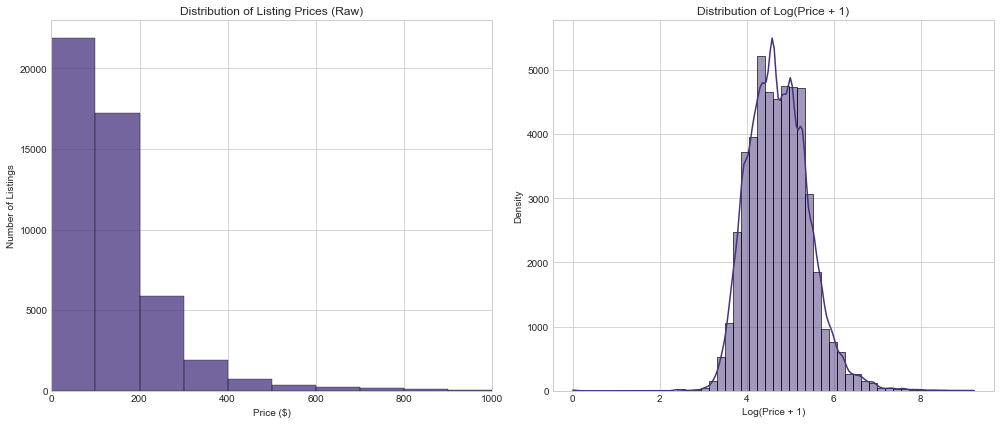

Number of listings with price $0: 11
Removed listings with price $0. New shape: (48884, 16)
99th percentile for price: $799.00


In [4]:
if not df.empty:
    # --- Price Distribution ---
    plt.figure(figsize=(14, 6))

    plt.subplot(1, 2, 1)
    sns.histplot(df['price'], bins=100, kde=False)
    plt.title('Distribution of Listing Prices (Raw)')
    plt.xlabel('Price ($)')
    plt.ylabel('Number of Listings')
    plt.xlim(0, 1000) # Zoom in a bit

    # Let's try a log scale for price to handle the skewness
    plt.subplot(1, 2, 2)
    # Add 1 before taking log to handle potential price = 0
    sns.histplot(np.log1p(df['price']), bins=50, kde=True)
    plt.title('Distribution of Log(Price + 1)')
    plt.xlabel('Log(Price + 1)')
    plt.ylabel('Density')

    plt.tight_layout()
    plt.show()

    # --- Outlier Check ---
    # How many listings have price $0?
    zero_price_listings = df[df['price'] == 0]
    print(f"Number of listings with price $0: {len(zero_price_listings)}")
    # Let's remove these as they seem like errors or free stays, not typical rentals.
    df = df[df['price'] > 0].copy()
    print(f"Removed listings with price $0. New shape: {df.shape}")

    # What about very high prices? Let's check the 99th percentile.
    price_99_percentile = df['price'].quantile(0.99)
    print(f"99th percentile for price: ${price_99_percentile:.2f}")
    # For visualizations, I might filter out extreme prices, but I'll keep them in the main df for now.
    df_viz = df[df['price'] <= price_99_percentile] # Create a separate df for clearer viz

else:
    print("DataFrame is empty, skipping visualizations.")

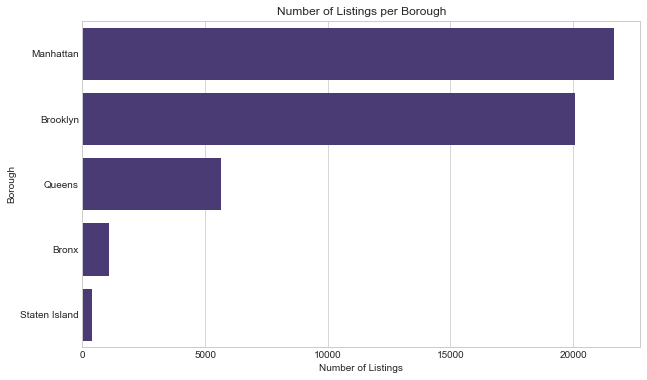

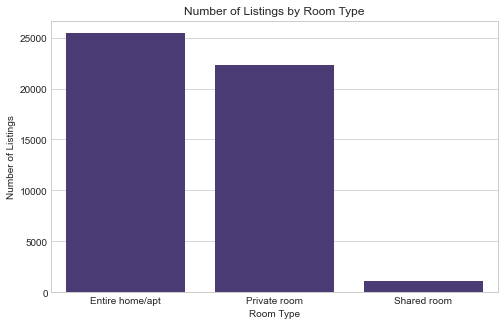

In [5]:
if not df.empty:
    # --- Listings per Borough ---
    plt.figure(figsize=(10, 6))
    sns.countplot(data=df, y='neighbourhood_group', order=df['neighbourhood_group'].value_counts().index)
    plt.title('Number of Listings per Borough')
    plt.xlabel('Number of Listings')
    plt.ylabel('Borough')
    plt.show()

    # --- Listings by Room Type ---
    plt.figure(figsize=(8, 5))
    sns.countplot(data=df, x='room_type', order=df['room_type'].value_counts().index)
    plt.title('Number of Listings by Room Type')
    plt.xlabel('Room Type')
    plt.ylabel('Number of Listings')
    plt.show()
else:
    print("DataFrame is empty, skipping visualizations.")

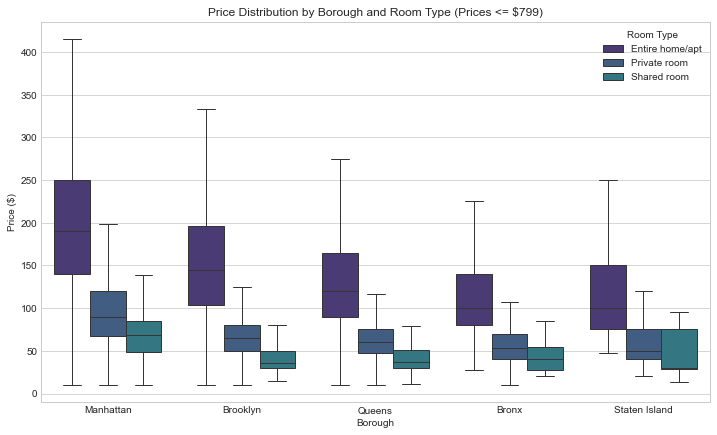

In [6]:
if not df.empty:
    # --- Price by Borough and Room Type (Using df_viz for clarity) ---
    plt.figure(figsize=(12, 7))
    # Using the filtered df_viz (price <= 99th percentile)
    sns.boxplot(data=df_viz, x='neighbourhood_group', y='price', hue='room_type',
                order=df['neighbourhood_group'].value_counts().index, # Order boroughs by listing count
                hue_order=['Entire home/apt', 'Private room', 'Shared room'],
                showfliers=False) # Hide outliers for this plot
    plt.title(f'Price Distribution by Borough and Room Type (Prices <= ${price_99_percentile:.0f})')
    plt.xlabel('Borough')
    plt.ylabel('Price ($)')
    plt.legend(title='Room Type')
    plt.show()
else:
    print("DataFrame is empty, skipping visualizations.")

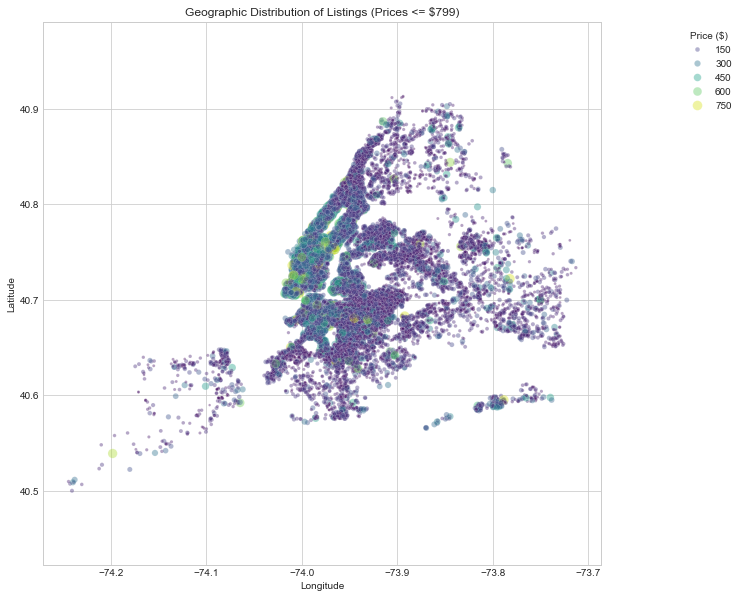

In [7]:
if not df.empty:
    # --- Simple Map using Latitude/Longitude ---
    # This gives a rough idea of listing density and price hotspots
    plt.figure(figsize=(10, 10))
    # Using df_viz again, sample helps performance if dataset is huge
    sns.scatterplot(data=df_viz.sample(min(len(df_viz), 50000), random_state=42), # Sample to avoid overplotting
                    x='longitude', y='latitude',
                    hue='price', size='price',
                    palette='viridis', alpha=0.4,
                    sizes=(5, 100), hue_norm=(0, price_99_percentile))
    plt.title(f'Geographic Distribution of Listings (Prices <= ${price_99_percentile:.0f})')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.legend(title='Price ($)', loc='upper right', bbox_to_anchor=(1.25, 1))
    plt.axis('equal') # Keep aspect ratio for map
    plt.show()
else:
    print("DataFrame is empty, skipping visualizations.")

**Visualization Insights:**
* Removed the 11 listings with $0 price. The log-transform plot shows a somewhat more normal distribution for price, but still some complexity.
* Confirmed Manhattan and Brooklyn dominate listings. 'Entire home/apt' and 'Private room' are the most common room types.
* The box plot clearly shows Manhattan is generally the most expensive borough, especially for entire homes. Staten Island seems the cheapest.
* The scatter plot map gives a nice visual overview. You can clearly see the concentration of listings (and higher prices) in Manhattan, spreading into Brooklyn and parts of Queens.

## 4. Feature Engineering

Let's create one potentially useful feature: how long ago the last review was posted. This might indicate how active or popular a listing is. We need a reference date; let's use the maximum date found in the `last_review` column as our 'today'.

Most recent review date in dataset: 2019-07-08
Missing values in 'days_since_last_review' before fill: 10051
Filled missing 'days_since_last_review' with 3389.0. Missing values now: 0

First 5 rows with new feature:


,last_review,days_since_last_review
0,2018-10-19,262.0
1,2019-05-21,48.0
2,NaT,3389.0
3,2019-07-05,3.0
4,2018-11-19,231.0


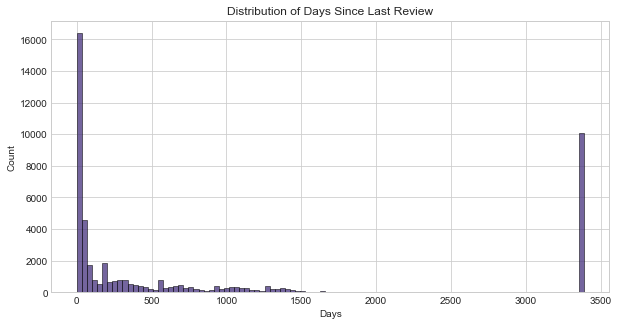

In [8]:
if not df.empty:
    # Calculate 'days_since_last_review'
    # Find the most recent review date in the entire dataset
    most_recent_review_date = df['last_review'].max()
    print(f"Most recent review date in dataset: {most_recent_review_date.date()}")

    # Calculate the difference in days
    # .dt.days extracts the number of days from the timedelta object
    df['days_since_last_review'] = (most_recent_review_date - df['last_review']).dt.days

    # For listings that never had a review (last_review is NaT), this difference will be NaN.
    # Let's check how many NaNs we have in the new column
    print(f"Missing values in 'days_since_last_review' before fill: {df['days_since_last_review'].isnull().sum()}")

    # We could fill these NaNs. A large number might represent listings with no review history.
    # Let's fill with a value significantly larger than the max observed days, e.g., 9999
    max_days = df['days_since_last_review'].max()
    fill_value = max_days + 365 # Arbitrarily one year more than max days
    # A very large number could also work: fill_value = 9999
    df['days_since_last_review'].fillna(fill_value, inplace=True)
    print(f"Filled missing 'days_since_last_review' with {fill_value}. Missing values now: {df['days_since_last_review'].isnull().sum()}")

    # Display result
    print("\nFirst 5 rows with new feature:")
    display(df[['last_review', 'days_since_last_review']].head())

    # Let's check the distribution of this new feature
    plt.figure(figsize=(10, 5))
    sns.histplot(df['days_since_last_review'], bins=100)
    plt.title('Distribution of Days Since Last Review')
    plt.xlabel('Days')
    plt.show()
else:
    print("DataFrame is empty, skipping feature engineering.")

Looks like the feature was created correctly. The large spike around the `fill_value` represents all the listings that never had reviews. Most reviewed listings seem to have relatively recent reviews (low number of days).

## 5. Export Cleaned Data for Tableau

Now that we've done some basic cleaning and added a feature, let's save this processed DataFrame. This CSV will be the input for our Tableau dashboard.

In [9]:
if not df.empty:
    try:
        df.to_csv(OUTPUT_FILE, index=False)
        print(f"Cleaned data exported successfully to {OUTPUT_FILE}")
    except Exception as e:
        print(f"---! ERROR exporting data !---")
        print(e)
else:
    print("DataFrame is empty, nothing to export.")

Cleaned data exported successfully to output/nyc_airbnb_cleaned.csv


## 6. Next Steps: Tableau Visualization

The Python analysis is done for now. The next step is to open Tableau Desktop and connect to the `nyc_airbnb_cleaned.csv` file we just created in the `output/` folder.

**Ideas for Tableau Dashboards/Worksheets:**

1.  **Overview Dashboard:**
    * KPIs: Total Listings, Average Price, Average Availability, Total Hosts.
    * Map: Listings colored by price or neighbourhood group. Use latitude and longitude.
    * Bar Charts: Number of listings by `neighbourhood_group` and `room_type`.
    * Filters: Allow filtering by Borough (`neighbourhood_group`) and `room_type`.

2.  **Price Analysis Worksheet:**
    * Map: Average price by `neighbourhood`.
    * Box Plots: Price distribution by `neighbourhood_group` and `room_type` (similar to the seaborn plot).
    * Histogram: Distribution of prices (maybe use bins or a log scale).
    * Filters: Price range, Borough, Room Type.

3.  **Availability & Reviews Worksheet:**
    * Histogram/Box Plot: Distribution of `availability_365`.
    * Scatter Plot: `price` vs. `number_of_reviews` or `price` vs. `reviews_per_month`.
    * Scatter Plot: `price` vs. `days_since_last_review`.
    * Map: Average availability or average `number_of_reviews` by neighborhood.
    * Filters: Availability range, Borough.

Remember to make the dashboards interactive using filters and highlighting actions!